In [1]:
import os
import random
import shutil
import pathlib


In [2]:
# now the task for transfer learning start
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = pathlib.Path("train")

batch_size = 32
img_height = 299
img_width = 299

IMG_SIZE = (img_height, img_width)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path("val"),
    #validation_split=0.2,
    #subset="validation",
    #seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
    )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path("test"),
    #validation_split=0.2,
    #subset="validation",
    #seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
    )

class_names = train_ds.class_names
print(class_names)


Found 25920 files belonging to 4 classes.
Found 6480 files belonging to 4 classes.
Found 3600 files belonging to 4 classes.
['clear', 'dirty', 'obstruction', 'shadow']


In [3]:
# F1 score functions

from tensorflow.keras import backend as K


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [4]:
# data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, fill_mode="nearest"),
    #tf.keras.layers.experimental.preprocessing.RandomTranslation(0.5, 0.5, fill_mode="wrap"),
    #tf.keras.layers.experimental.preprocessing.RandomZoom(0.5, fill_mode="nearest"),
    #tf.keras.layers.experimental.preprocessing.RandomCrop(100, 100),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.5),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.5),
])


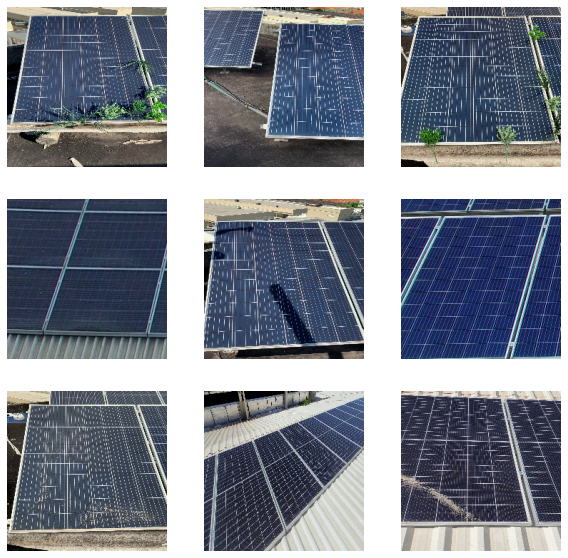

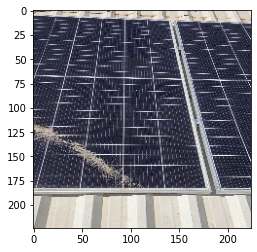

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
image = None
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")
    image = images[i].numpy().astype("uint8")

plt.figure()
plt.imshow(image)


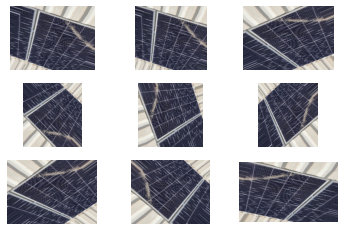

In [20]:
plt.figure()
#augmented_image = data_augmentation(tf.expand_dims(image, 0))
#plt.imshow(augmented_image[0] / 255)
#plt.axis("off")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [5]:
# https://keras.io/api/applications/
# Xception
preprocess_input = tf.keras.applications.xception.preprocess_input

# Create the base model from the pre-trained model  Xception
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Show the model architecture
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(
    len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_m])

model.summary()


83683744/83683744 [==============================] - 7s 0us/step
(32, 10, 10, 2048)
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)

In [6]:
# first evaluation before training 
model.evaluate(val_ds)



203/203 [==============================] - 41s 189ms/step - loss: 1.4847 - accuracy: 0.2637 - f1_m: 0.0030


[1.4847447872161865, 0.2637345790863037, 0.002959177130833268]

In [7]:
# training process without fine tunning 
initial_epochs = 20
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


Epoch 1/20
810/810 [==============================] - 779s 959ms/step - loss: 0.9478 - accuracy: 0.6960 - f1_m: 0.3997 - val_loss: 0.7821 - val_accuracy: 0.8647 - val_f1_m: 0.5878
Epoch 2/20
810/810 [==============================] - 680s 840ms/step - loss: 0.5911 - accuracy: 0.8470 - f1_m: 0.7839 - val_loss: 0.5965 - val_accuracy: 0.8869 - val_f1_m: 0.8176
Epoch 3/20
810/810 [==============================] - 583s 720ms/step - loss: 0.4706 - accuracy: 0.8716 - f1_m: 0.8499 - val_loss: 0.5075 - val_accuracy: 0.9012 - val_f1_m: 0.8590
Epoch 4/20
810/810 [==============================] - 541s 668ms/step - loss: 0.4020 - accuracy: 0.8861 - f1_m: 0.8748 - val_loss: 0.4445 - val_accuracy: 0.9130 - val_f1_m: 0.8817
Epoch 5/20
810/810 [==============================] - 534s 658ms/step - loss: 0.3641 - accuracy: 0.8973 - f1_m: 0.8877 - val_loss: 0.4069 - val_accuracy: 0.9111 - val_f1_m: 0.8886
Epoch 6/20
810/810 [==============================] - 542s 669ms/step - loss: 0.3366 - accuracy: 0.9

In [8]:
# new evaluation after training
model.evaluate(test_ds)


113/113 [==============================] - 21s 178ms/step - loss: 0.2471 - accuracy: 0.9397 - f1_m: 0.9336


[0.24711094796657562, 0.9397222399711609, 0.9336472749710083]

In [9]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.

base_file_name = "xception_tl_au"
model.save(base_file_name + '_model.h5')


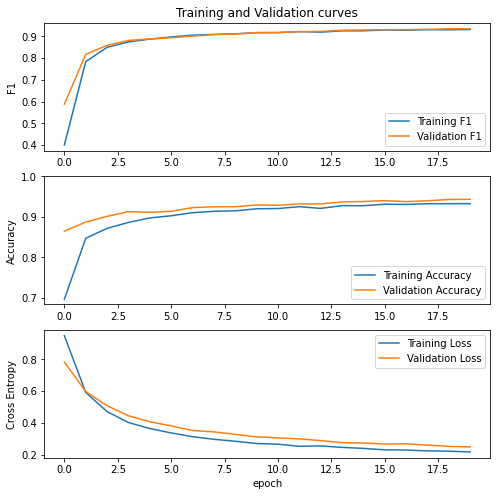

In [10]:
# plot training curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

loss = history.history['loss']
val_loss = history.history['val_loss']

f = open(base_file_name + "_model.txt", "a")
f.write(f"acurracy\tval_accuracy\tloss\tval_loss\tf1\tval_f1\n")
for i in range(len(acc)):
  f.write(f"{acc[i]}\t{val_acc[i]}\t{loss[i]}\t{val_loss[i]}\t{f1}\t{val_f1}\n")

f.close()

plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
plt.plot(f1, label='Training F1')
plt.plot(val_f1, label='Validation F1')
plt.legend(loc='lower right')
plt.ylabel('F1')
plt.title('Training and Validation curves')
#plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
#plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 3)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(
    f"{base_file_name}_model.png"
)
#plt.close()


In [11]:
# contruct prediction vector to make the confusion matrix

predictions = np.array([])
labels = np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


1/1 [==============================] - 0s 494ms/step


In [44]:
# fine tunning
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
# for mobilenetv2 let train 54 layers
fine_tune_at = 54


Number of layers in the base model:  154


In [45]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_m])

model.summary()
len(model.trainable_variables)
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

# after


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0   

In [46]:
# Save the entire fine tunning model to a HDF5 file.

model.save(base_file_name + 'fine_tunning_model.h5')


C:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


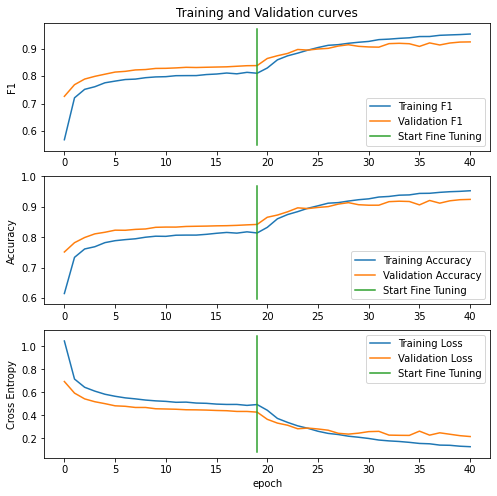

In [50]:
import matplotlib.pyplot as plt

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

f1 += history_fine.history['f1_m']
val_f1 += history_fine.history['val_f1_m']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

f = open(base_file_name + "fine_tunning_model.txt", "a")
f.write(f"acurracy\tval_accuracy\tloss\tval_loss\tf1\tval_f1\n")
for i in range(len(acc)):
  f.write(f"{acc[i]}\t{val_acc[i]}\t{loss[i]}\t{val_loss[i]}\t{f1}\t{val_f1}\n")

f.close()

plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
plt.plot(f1, label='Training F1')
plt.plot(val_f1, label='Validation F1')
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('F1')
plt.title('Training and Validation curves')
#plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
#plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 3)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(
    f"{base_file_name}_fine_tunning_model.png"
)


<Figure size 432x288 with 0 Axes>

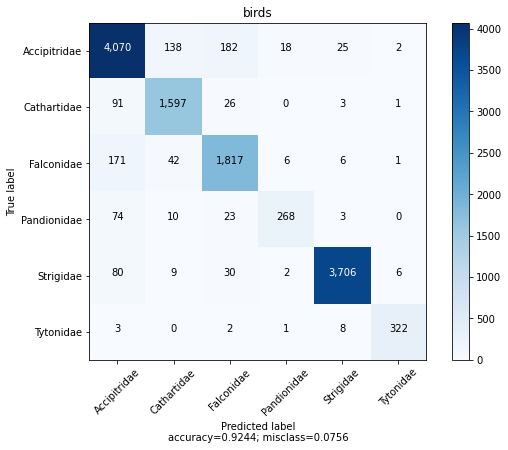

In [51]:
predictions = np.array([])
labels = np.array([])
for x, y in test_ds:
  predictions = np.concatenate(
      [predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

M = confusion_matrix(labels, predictions)
plot_confusion_matrix(M, normalize=False,
                      target_names=test_ds.class_names, title="birds")
